In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

In [4]:
import sys
import os
from collections import defaultdict, Counter

In [5]:
import math

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

## Constants

In [7]:
data_path = "/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability"

## Get paths of files

In [8]:
base_file_dict = defaultdict(list)
other_1_file_dict = defaultdict(list)
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path.endswith('parquet'):
            file_type = 'train' if 'train' in file_path else 'test'
            if 'base' in file_path:
                base_file_dict[file_type].append(file_path)
            if 'other_1' in file_path:
                other_1_file_dict[file_type].append(file_path)

In [9]:
other_1_file_dict.get("train")

['/Users/hardiksahi/Personal/MachineLearning/kaggle/home-credit-risk-model-stability/data/01_raw/home-credit-credit-risk-model-stability/parquet_files/train/train_other_1.parquet']

## Functions

In [10]:
def get_column_description(feature_def_df, column_name):
    return feature_def_df[feature_def_df.Variable == column_name]['Description'].iloc[0]

In [11]:
def plot_scatterplot(df, x_col_name, y_col_name, show_x_y_line=False):
    assert x_col_name in df.columns, f"Ensure that {x_col_name} is in the df"
    assert y_col_name in df.columns, f"Ensure that {y_col_name} is in the df"
    
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x=df[x_col_name], y=df[y_col_name], ax=axs)
    
    if show_x_y_line:
        df[x_col_name] = df[x_col_name].replace([np.inf, -np.inf], np.nan)
        df[y_col_name] = df[y_col_name].replace([np.inf, -np.inf], np.nan)
        not_null_x_filter = ~df[x_col_name].isnull()
        not_null_y_filter = ~df[y_col_name].isnull()
        not_null_filter = not_null_x_filter & not_null_y_filter
        filtered_df = df[not_null_filter]
        x_values_series = filtered_df[x_col_name]
        y_values_series = filtered_df[y_col_name]
        x0, x1 = min(x_values_series), max(x_values_series)
        y0, y1 = min(y_values_series), max(y_values_series)
        #line_values = [i for i in np.arange(min(x0, y0), max(x1, y1), 0.1)]
        lims = [min(x0, y0), max(x1, y1)]
        print(f"lims: {lims}")
        plt.plot(lims, lims)
    return fig

In [12]:
def get_percent_of_column(df, groupby_column, target_column):
    target_df = df.groupby(by=[groupby_column]).agg({target_column:"sum"}).reset_index()
    all_rows_df = df.groupby(by=[groupby_column]).size().reset_index().rename({0:"total_rows"}, axis=1)
    merged_df = target_df.merge(all_rows_df, left_on=[groupby_column], right_on=[groupby_column], how="left")
    merged_df["percentage_default"] = 100*merged_df["target"]/merged_df["total_rows"]
    merged_df[groupby_column] = merged_df[groupby_column].astype(str)
    return merged_df

In [13]:
def plot_barplot(df, percent_column, category_column):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(ax=ax, data=df, y=category_column, x=percent_column, order=df.sort_values(by=[percent_column], ascending=False)[category_column].values)
    return fig

In [34]:
def get_relevant_indices(series):
    percentile_25 = series.quantile(0.25)
    percentile_75 = series.quantile(0.75)
    iqr = percentile_75-percentile_25
    upper_limit = percentile_75 + 1.5*iqr
    lower_limit = percentile_25 - 1.5*iqr

    keep_indices = series[(series>=lower_limit) & (series<=upper_limit)].index
    return keep_indices 

## Read datasets

In [14]:
feature_df = pd.read_csv(f"{data_path}/feature_definitions.csv")
print(f"Shape of feature_df: {feature_df.shape}")

Shape of feature_df: (465, 2)


## Properties: depth=1, internal data source

In [15]:
train_other_1_df = pd.concat([pd.read_parquet(file_path) for file_path in other_1_file_dict['train']], axis=0)
print(f"Shape of train_other_1_df: {train_other_1_df.shape}")

Shape of train_other_1_df: (51109, 7)


## This means that there are multiple rows for each case_id indexed by num_group1

In [18]:
unique_num_group_case_id_df = train_other_1_df.groupby(by=["case_id"]).agg({"num_group1": "nunique"}).reset_index().rename({"num_group1": "generated_count_of_previous_applications"}, axis=1)

In [20]:
unique_num_group_case_id_df.generated_count_of_previous_applications.value_counts()

generated_count_of_previous_applications
1    51109
Name: count, dtype: int64

In [23]:
train_other_1_df.num_group1.value_counts()

num_group1
0    51109
Name: count, dtype: int64

### 1. amtdebitincoming_4809443A

In [35]:
get_column_description(feature_df, "amtdebitincoming_4809443A")

'Incoming debit card transactions amount.'

In [36]:
amtdebitincoming_4809443A_indices = get_relevant_indices(train_other_1_df.amtdebitincoming_4809443A) 

<Axes: ylabel='amtdebitincoming_4809443A'>

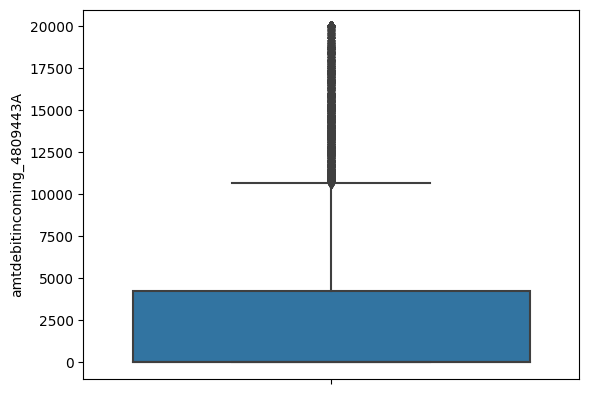

In [37]:
sns.boxplot(data=train_other_1_df.loc[amtdebitincoming_4809443A_indices], y="amtdebitincoming_4809443A") 

### 2. amtdebitoutgoing_4809440A

In [38]:
get_column_description(feature_df, "amtdebitoutgoing_4809440A")

'Outgoing debit card transactions amount.'

In [39]:
amtdebitoutgoing_4809440A_indices = get_relevant_indices(train_other_1_df.amtdebitoutgoing_4809440A) 

<Axes: ylabel='amtdebitoutgoing_4809440A'>

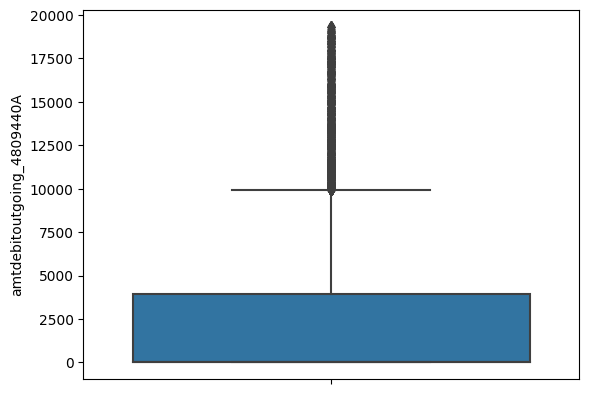

In [41]:
sns.boxplot(data=train_other_1_df.loc[amtdebitoutgoing_4809440A_indices], y="amtdebitoutgoing_4809440A")

### 3. amtdepositbalance_4809441A

In [42]:
get_column_description(feature_df, "amtdepositbalance_4809441A")

'Deposit balance of client.'

In [43]:
amtdepositbalance_4809441A_indices = get_relevant_indices(train_other_1_df.amtdepositbalance_4809441A) 

<Axes: ylabel='amtdepositbalance_4809441A'>

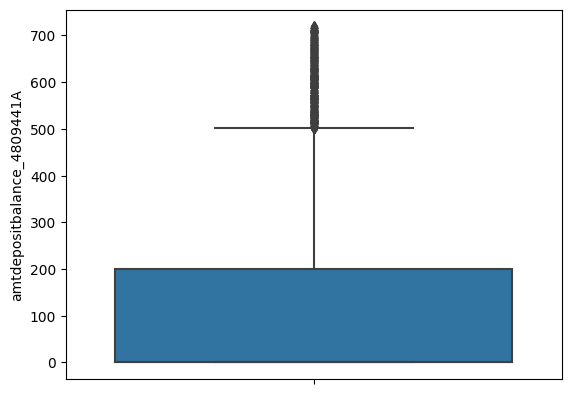

In [44]:
sns.boxplot(data=train_other_1_df.loc[amtdepositbalance_4809441A_indices], y="amtdepositbalance_4809441A")

### 4. amtdepositincoming_4809444A

In [45]:
get_column_description(feature_df, "amtdepositincoming_4809444A")

"Amount of incoming deposits to client's account."

In [46]:
amtdepositincoming_4809444A_indices = get_relevant_indices(train_other_1_df.amtdepositincoming_4809444A) 

<Axes: ylabel='amtdepositincoming_4809444A'>

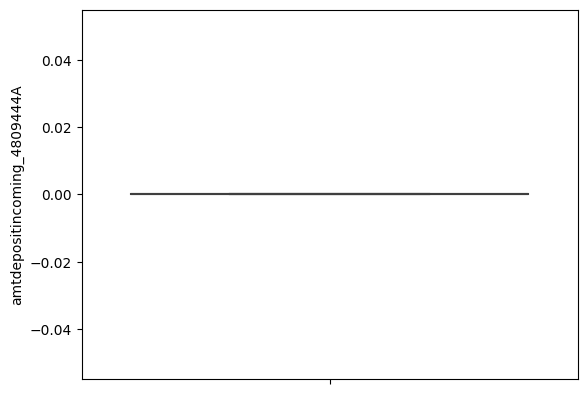

In [47]:
sns.boxplot(data=train_other_1_df.loc[amtdepositincoming_4809444A_indices], y="amtdepositincoming_4809444A")

<Axes: ylabel='amtdepositincoming_4809444A'>

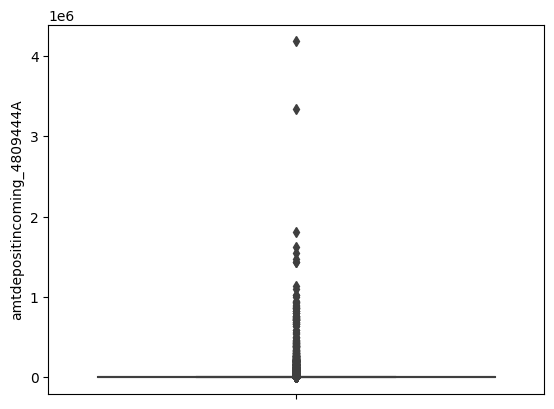

In [48]:
sns.boxplot(data=train_other_1_df, y="amtdepositincoming_4809444A")

### 5. amtdepositoutgoing_4809442A

In [49]:
get_column_description(feature_df, "amtdepositoutgoing_4809442A")

"Amount of outgoing deposits from client's account."

In [50]:
amtdepositoutgoing_4809442A_indices = get_relevant_indices(train_other_1_df.amtdepositoutgoing_4809442A) 

<Axes: ylabel='amtdepositoutgoing_4809442A'>

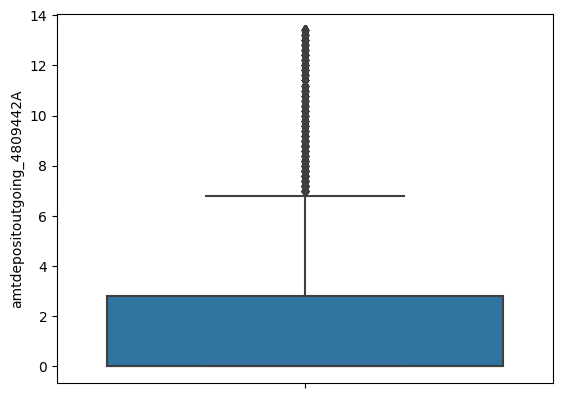

In [51]:
sns.boxplot(data=train_other_1_df.loc[amtdepositoutgoing_4809442A_indices], y="amtdepositoutgoing_4809442A")